The stitched image is saved at: output/stitched_image_20221221_204202.jpg


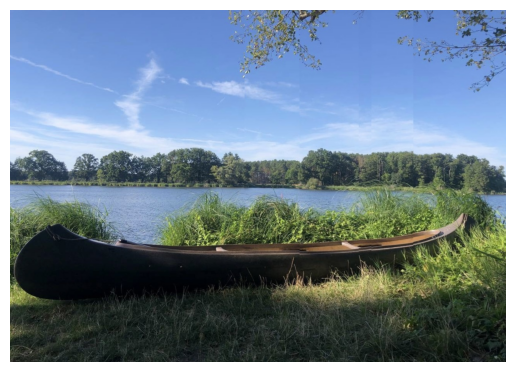

In [58]:
import imgstitch
import matplotlib.pyplot as plt
import cv2

reslist = ['1.jpg','2.jpg','3.jpg','4.jpg','5.jpg','6.jpg','7.jpg','8.jpg','9.jpg']
stitched = imgstitch.stitch_images_and_save("images", reslist, 1)
filename = 'output/stitched_image_20221221_203817.jpg'
image = cv2.imread(filename)
imgRes = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(imgRes)
plt.show()

In [50]:
import cv2
import glob
import matplotlib.pyplot as plt
import math

#Read images

imagefiles = glob.glob("images2/*")
imagefiles.sort()

images = []

for filename in imagefiles:
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

num_images = len(images)



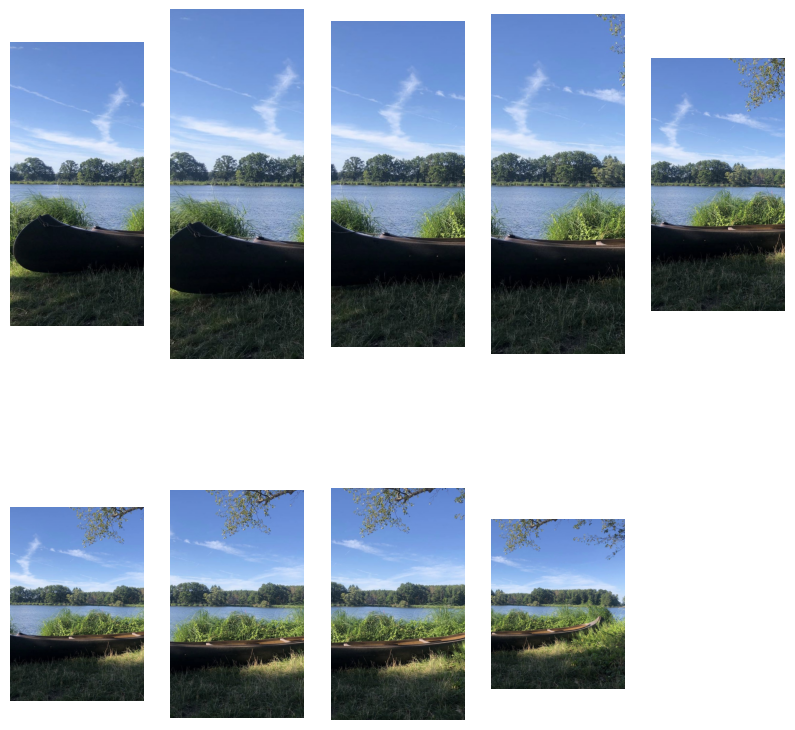

In [59]:
#display images

plt.figure(figsize=[10,10])
num_cols = 5
num_rows = math.ceil(num_images / num_cols)
for i in range(0, num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.axis('off')
    plt.imshow(images[i])

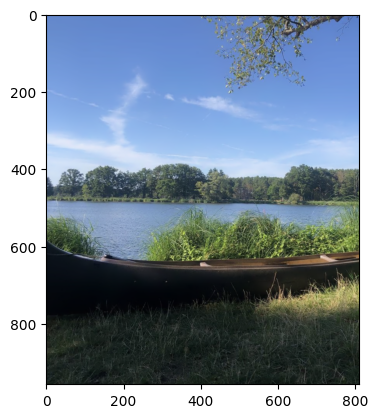

In [62]:
#stitch images

stitcher = cv2.Stitcher_create()
status, result = stitcher.stitch(images)
if status == 0:
    plt.imshow(result)